In [249]:
import pandas as pd
import tensorflow as tf
import keras
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Model
from keras.layers import Dense, Input, Embedding, Concatenate, Flatten
import matplotlib.pyplot as plt

In [250]:
ratings = pd.read_csv('ratings_small.csv').sample(frac=1, random_state=42)
movies = pd.read_csv('movies_small.csv').sample(frac=1, random_state=42)
df = pd.merge(movies, ratings, on=['movieId', 'movieId'], how='inner')

In [251]:
df.head()

,movieId,title,genres,userId,rating,timestamp
0,45635,"Notorious Bettie Page, The (2005)",Drama,414,3.0,1216149238
1,45635,"Notorious Bettie Page, The (2005)",Drama,474,3.0,1165540175
2,1373,Star Trek V: The Final Frontier (1989),Action|Sci-Fi,288,2.5,1088172808
3,1373,Star Trek V: The Final Frontier (1989),Action|Sci-Fi,294,3.0,966634266
4,1373,Star Trek V: The Final Frontier (1989),Action|Sci-Fi,19,1.0,965703973


In [252]:
COLS = ['movieId', 'title', 'genres', 'userId', 'rating']

In [253]:
df.drop(columns=['timestamp'], inplace=True)
# df.columns = COLS
df.describe()

,movieId,userId,rating
count,100836.000000,100836.000000,100836.000000
mean,19435.295718,326.127564,3.501557
std,35530.987199,182.618491,1.042529
min,1.000000,1.000000,0.500000
25%,1199.000000,177.000000,3.000000
50%,2991.000000,325.000000,3.500000
75%,8122.000000,477.000000,4.000000
max,193609.000000,610.000000,5.000000


In [254]:
df.dtypes

movieId      int64
title       object
genres      object
userId       int64
rating     float64
dtype: object

### Declare constants

In [255]:
BATCH_SIZE = 256

In [256]:
N_TEST = round(len(df) * .2)   # 20% for test
trainf, test = df.iloc[N_TEST:, :], df.iloc[:N_TEST, :]

trainf_X, trainf_y = trainf.iloc[:,:-1], trainf.iloc[:,-1]
centering_factor = trainf.rating.mean()
trainf_y -= centering_factor

test_X, test_y = test.iloc[:,:-1], test.iloc[:,-1]
test_y -= centering_factor

In [257]:
centering_factor

3.5083985173982573

In [258]:
trainf_X

,movieId,title,genres,userId
20167,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,113
20168,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,46
20169,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,199
20170,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,561
20171,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,357
...,...,...,...,...
100831,1131,Jean de Florette (1986),Drama|Mystery,547
100832,1131,Jean de Florette (1986),Drama|Mystery,202
100833,1131,Jean de Florette (1986),Drama|Mystery,372
100834,1131,Jean de Florette (1986),Drama|Mystery,84


In [259]:
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     0.0001,
#     decay_steps=2000,
#     decay_rate=0.96,
#     staircase=True)


In [260]:
EMBEDDING_SIZE = 5
EPOCHS = 30

inputs1 = Input(shape=(1,), name='userId') # userId
inputs2 = Input(shape=(1,), name='movieId') # movieId

embedding1 = Embedding(df.userId.max()+1, EMBEDDING_SIZE, input_length=1, name='userId_Embedding')(inputs1)
embedding2 = Embedding(df.movieId.max()+1, EMBEDDING_SIZE, input_length=1, name='movieId_Embedding')(inputs2)

c = Concatenate()([embedding1, embedding2])
x = Dense(32, activation='relu', name='relu1')(c)
x = Dense(16, activation='relu', name='relu2')(x)
y = Dense(1, activation='linear' ,name='output')(x)

model = Model(inputs=[inputs1, inputs2], outputs=y, name='DL_Recommender')
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='MSE',
    metrics=['MAE']
    )

model.summary()

Model: "DL_Recommender"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
userId (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
movieId (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
userId_Embedding (Embedding)    (None, 1, 5)         3055        userId[0][0]                     
__________________________________________________________________________________________________
movieId_Embedding (Embedding)   (None, 1, 5)         968050      movieId[0][0]                    
_____________________________________________________________________________________

In [261]:
history = model.fit(x=[trainf_X.userId, trainf_X.movieId], y=trainf_y, epochs=30, validation_split=.1, batch_size=BATCH_SIZE)

Epoch 1/30
284/284 [==============================] - 3s 10ms/step - loss: 1.0889 - MAE: 0.8296 - val_loss: 1.0223 - val_MAE: 0.8014
Epoch 2/30
284/284 [==============================] - 3s 11ms/step - loss: 1.0522 - MAE: 0.8160 - val_loss: 0.9704 - val_MAE: 0.7817
Epoch 3/30
284/284 [==============================] - 3s 10ms/step - loss: 0.9520 - MAE: 0.7700 - val_loss: 0.8992 - val_MAE: 0.7434
Epoch 4/30
284/284 [==============================] - 3s 9ms/step - loss: 0.8390 - MAE: 0.7100 - val_loss: 0.8832 - val_MAE: 0.7368
Epoch 5/30
284/284 [==============================] - 3s 10ms/step - loss: 0.7719 - MAE: 0.6775 - val_loss: 0.8970 - val_MAE: 0.7460
Epoch 6/30
284/284 [==============================] - 2s 9ms/step - loss: 0.7346 - MAE: 0.6589 - val_loss: 0.9097 - val_MAE: 0.7520
Epoch 7/30
284/284 [==============================] - 2s 9ms/step - loss: 0.7109 - MAE: 0.6468 - val_loss: 0.9195 - val_MAE: 0.7554
Epoch 8/30
284/284 [==============================] - 3s 11ms/step - los

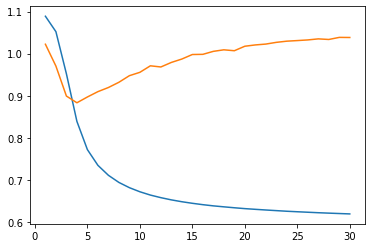

In [262]:
plt.plot([i for i in range(1, EPOCHS+1)], history.history['loss'])
plt.plot([i for i in range(1, EPOCHS+1)], history.history['val_loss'])

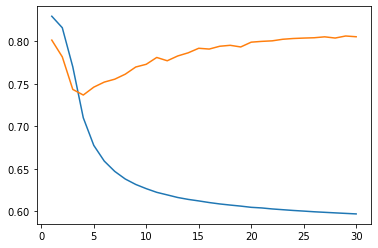

In [263]:
plt.plot([i for i in range(1, EPOCHS+1)], history.history['MAE'])
plt.plot([i for i in range(1, EPOCHS+1)], history.history['val_MAE'])

### 4 epochs seems to be ideal

In [264]:
model_final = Model(inputs=[inputs1, inputs2], outputs=y)
model_final.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='MSE',
    metrics=['MAE']
)

In [265]:
history = model_final.fit(x=[trainf_X.userId, trainf_X.movieId], y=trainf_y, epochs=15, batch_size=BATCH_SIZE)

Epoch 1/15
316/316 [==============================] - 3s 10ms/step - loss: 0.6829 - MAE: 0.6303
Epoch 2/15
316/316 [==============================] - 3s 9ms/step - loss: 0.6572 - MAE: 0.6178A: 0s - loss: 0.6512
Epoch 3/15
316/316 [==============================] - 3s 9ms/step - loss: 0.6404 - MAE: 0.6098
Epoch 4/15
316/316 [==============================] - 3s 9ms/step - loss: 0.6276 - MAE: 0.6019
Epoch 5/15
316/316 [==============================] - 3s 8ms/step - loss: 0.6161 - MAE: 0.5958
Epoch 6/15
316/316 [==============================] - 3s 9ms/step - loss: 0.6043 - MAE: 0.5891
Epoch 7/15
316/316 [==============================] - 3s 9ms/step - loss: 0.5925 - MAE: 0.5829
Epoch 8/15
316/316 [==============================] - 3s 10ms/step - loss: 0.5798 - MAE: 0.5756
Epoch 9/15
316/316 [==============================] - 3s 9ms/step - loss: 0.5678 - MAE: 0.5694
Epoch 10/15
316/316 [==============================] - 3s 8ms/step - loss: 0.5557 - MAE: 0.5622
Epoch 11/15
316/316 [======

In [266]:
y_pred = model_final.predict([test_X.userId, test_X.movieId])

In [267]:
y_pred = y_pred.reshape(len(y_pred),)

In [268]:
mean_absolute_error(test_y, y_pred)

0.8090256476816976

### We can also treat the problem as classification!

In [269]:
N_TEST = round(len(df) * .2)   # 20% for test
trainf, test = df.iloc[N_TEST:, :], df.iloc[:N_TEST, :]
le = LabelEncoder()
trainf_X, trainf_y = trainf.iloc[:,:-1], trainf.iloc[:,-1]
trainf_y = le.fit_transform(trainf_y)
test_X, test_y = test.iloc[:,:-1], test.iloc[:,-1]
test_y = le.transform(test_y)

In [270]:
inputs1 = Input(shape=(1,), name='userId') # userId
inputs2 = Input(shape=(1,), name='movieId') # movieId

embedding1 = Embedding(df.userId.max()+1, EMBEDDING_SIZE, input_length=1, name='userId_Embedding')(inputs1)
embedding2 = Embedding(df.movieId.max()+1, EMBEDDING_SIZE, input_length=1, name='movieId_Embedding')(inputs2)

c = Concatenate()([embedding1, embedding2])
x = Dense(32, activation='relu', name='relu1')(c)
x = Dense(16, activation='relu', name='relu2')(x)
y = Dense(N_OUTPUTS, activation='softmax' ,name='output')(x)

model = Model(inputs=[inputs1, inputs2], outputs=y, name='DL_Recommender')
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
    )

model.summary()

Model: "DL_Recommender"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
userId (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
movieId (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
userId_Embedding (Embedding)    (None, 1, 5)         3055        userId[0][0]                     
__________________________________________________________________________________________________
movieId_Embedding (Embedding)   (None, 1, 5)         968050      movieId[0][0]                    
_____________________________________________________________________________________

In [271]:
history = model.fit(x=[trainf_X.userId, trainf_X.movieId], y=trainf_y, epochs=30, validation_split=.1, batch_size=BATCH_SIZE)

Epoch 1/30
284/284 [==============================] - 3s 10ms/step - loss: 2.2741 - acc: 0.2234 - val_loss: 2.2336 - val_acc: 0.2402
Epoch 2/30
284/284 [==============================] - 3s 10ms/step - loss: 2.1731 - acc: 0.2503 - val_loss: 2.0987 - val_acc: 0.2666
Epoch 3/30
284/284 [==============================] - 2s 9ms/step - loss: 2.0556 - acc: 0.2670 - val_loss: 2.0150 - val_acc: 0.2681
Epoch 4/30
284/284 [==============================] - 2s 9ms/step - loss: 1.9989 - acc: 0.2670 - val_loss: 1.9799 - val_acc: 0.2681
Epoch 5/30
284/284 [==============================] - 3s 10ms/step - loss: 1.9645 - acc: 0.2674 - val_loss: 1.9558 - val_acc: 0.2705
Epoch 6/30
284/284 [==============================] - 3s 9ms/step - loss: 1.9330 - acc: 0.2695 - val_loss: 1.9349 - val_acc: 0.2704
Epoch 7/30
284/284 [==============================] - 3s 9ms/step - loss: 1.9007 - acc: 0.2769 - val_loss: 1.9145 - val_acc: 0.2764
Epoch 8/30
284/284 [==============================] - 3s 9ms/step - loss:

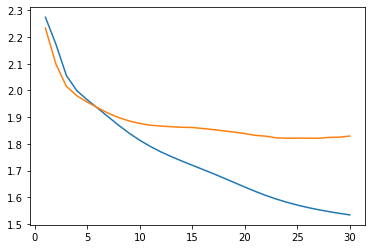

In [272]:
plt.plot([i for i in range(1, EPOCHS+1)], history.history['loss'])
plt.plot([i for i in range(1, EPOCHS+1)], history.history['val_loss'])

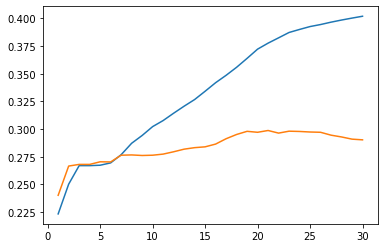

In [273]:
plt.plot([i for i in range(1, EPOCHS+1)], history.history['acc'])
plt.plot([i for i in range(1, EPOCHS+1)], history.history['val_acc'])

In [274]:
model_final = Model(inputs=[inputs1, inputs2], outputs=y)
model_final.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
     loss='sparse_categorical_crossentropy',
    metrics=['acc', 'MAE']
)

In [275]:
history = model_final.fit(x=[trainf_X.userId, trainf_X.movieId], y=trainf_y, epochs=4, batch_size=BATCH_SIZE)

Epoch 1/4
316/316 [==============================] - 3s 9ms/step - loss: 1.5696 - acc: 0.3834 - MAE: 5.9191
Epoch 2/4
316/316 [==============================] - 3s 10ms/step - loss: 1.5375 - acc: 0.3936 - MAE: 5.9197
Epoch 3/4
316/316 [==============================] - 4s 11ms/step - loss: 1.5167 - acc: 0.4031 - MAE: 5.9194
Epoch 4/4
316/316 [==============================] - 3s 11ms/step - loss: 1.4983 - acc: 0.4099 - MAE: 5.9194


In [276]:
from sklearn.metrics import accuracy_score
y_pred = np.argmax(model_final.predict([test_X.userId, test_X.movieId]), axis=-1)
y_pred = y_pred.reshape(len(y_pred),)

accuracy_score(test_y, y_pred), mean_absolute_error(le.inverse_transform(test_y), le.inverse_transform(y_pred))

(0.2718302176823524, 0.846283532503595)

In [277]:
N_OUTPUTS

10

In [278]:
np.argmax(model_final.predict([test_X.userId, test_X.movieId]), axis=-1)

array([[7],
       [6],
       [5],
       ...,
       [9],
       [9],
       [7]], dtype=int64)

In [279]:
y_pred, test_y

(array([7, 6, 5, ..., 9, 9, 7], dtype=int64),
 array([5, 5, 4, ..., 7, 9, 8], dtype=int64))